In [2]:
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.9/30.9 MB 76.1 MB/s eta 0:00:00


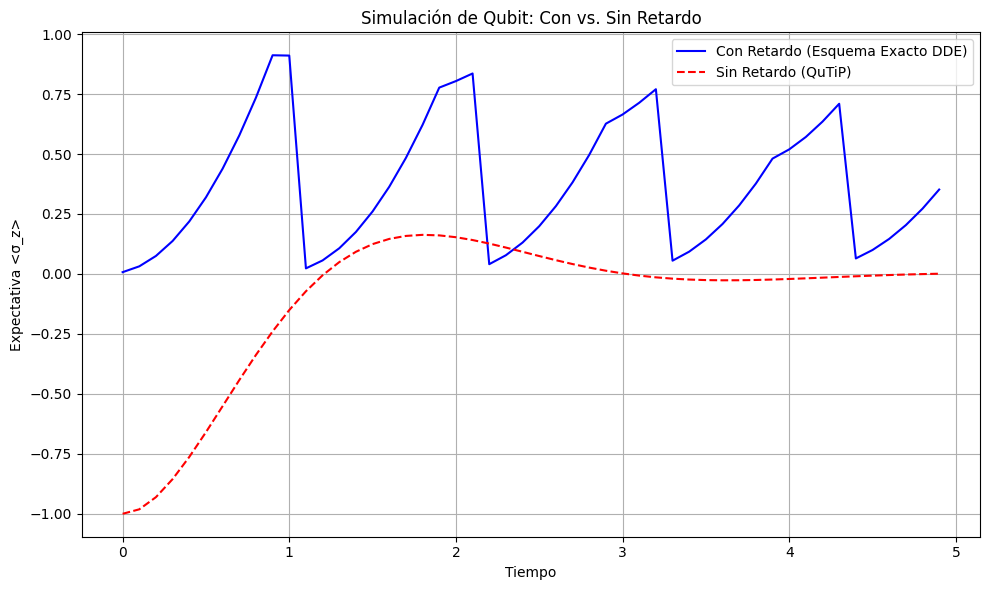

Tabla ANOVA:
             sum_sq    df          F        PR(>F)
C(Grupo)  5.764704   1.0  66.001725  1.377658e-12
Residual  8.559488  98.0        NaN           NaN


In [9]:
import numpy as np
import qutip as qt
from scipy.integrate import quad
from scipy.special import comb
from math import factorial
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import matplotlib.pyplot as plt

# Parámetros del modelo DDE
alpha = -1.0
beta = 0.5
gamma = 0.75
tau = 1.0
h = tau / 10
N = int(tau / h)
t_max = 5 * tau
n_steps = int(t_max / h)

# Función inicial phi(t)
def phi(t):
    return (t + 1)**2

def phi_prime(t):
    return 2 * (t + 1)

def F(s):
    return gamma * phi_prime(s) + beta * phi(s)

# Esquema exacto DDE
def exact_dde_step(x_prev, n, m):
    term1 = np.exp(alpha * h) * x_prev[n]

    term2 = 0
    for k in range(1, m):
        for r in range(1, k+1):
            binom = comb(k-1, r-1, exact=True)
            term2 += (gamma**(k-r)) * ((beta + alpha * gamma)**r) * (h**r / factorial(r)) * binom * x_prev[n - k*N]

    def integrand(s):
        inner_sum = gamma**(m-1)
        for k in range(1, m):
            for r in range(1, k+1):
                inner_sum += (gamma**(m-1-r)) * ((beta + alpha * gamma)**r) * (((n*h - m*tau + h - s)**r) / factorial(r))
        return inner_sum * np.exp(alpha * (n*h - m*tau + h - s)) * F(s)

    lower = n*h - m*tau
    upper = lower + h
    term3, _ = quad(integrand, lower, upper)

    return term1 + term2 + term3

# Simulación DDE
t = np.linspace(-tau, t_max, n_steps + N + 1)
x = np.zeros(len(t))
for i in range(N+1):
    x[i] = phi(t[i])

for n in range(0, n_steps):
    m = int(np.floor((n*h)/tau) + 1)
    x[n + N + 1] = exact_dde_step(x[:n + N + 1], n, m)

# Simulación cuántica (QuTiP) sin retardo
H = qt.sigmax()
psi0 = qt.basis(2, 1)
c_ops = [np.sqrt(-alpha) * qt.sigmaz()]
t_qutip = t[t >= 0]
result_no_delay = qt.mesolve(H, psi0, t_qutip, c_ops=c_ops, e_ops=[qt.sigmaz()])
sz_no_delay = result_no_delay.expect[0]

# 🔍 Ajustar longitudes
x_delay = x[N + 1:N + 1 + len(sz_no_delay)]
min_len = min(len(x_delay), len(sz_no_delay), len(t_qutip))

x_delay = x_delay[:min_len]
sz_no_delay = sz_no_delay[:min_len]
t_qutip = t_qutip[:min_len]

# Preparar DataFrame para ANOVA
data = pd.DataFrame({
    'Tiempo': np.tile(t_qutip, 2),
    'Valor': np.concatenate([x_delay, sz_no_delay]),
    'Grupo': ['Con Retardo'] * min_len + ['Sin Retardo'] * min_len
})

# ANOVA
model = ols('Valor ~ C(Grupo)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Visualización
plt.figure(figsize=(10, 6))
plt.plot(t_qutip, x_delay, label='Con Retardo (Esquema Exacto DDE)', color='blue')
plt.plot(t_qutip, sz_no_delay, label='Sin Retardo (QuTiP)', color='red', linestyle='--')
plt.xlabel('Tiempo')
plt.ylabel('Expectativa <σ_z>')
plt.title('Simulación de Qubit: Con vs. Sin Retardo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar tabla ANOVA
print("Tabla ANOVA:\n", anova_table)
